<a href="https://colab.research.google.com/github/arjunks95/healthcare-ml/blob/main/EMGEOG_sleepstagetracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Import Libraries

Name: Arjun K S

Student No: 523510

Mail : askasi@utu.fi

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
from scipy import signal
from scipy.stats import entropy
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn import metrics
from numpy import linspace, max, min, average, std, sum, sqrt, where, argmax
from scipy.integrate import cumtrapz
from scipy.signal import welch
from numpy import array, mean, average, linspace, where
from numpy.random import normal
import scipy

In [ ]:
#extract from zip file- Initial step
'''
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Bio-analytics/Data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/Bio-analytics')'''

In [ ]:
#signal features
fs=200.0
num_channels=2
sample_size=60
path='/content/drive/MyDrive/Bio-analytics/Data/Train/'
class_list=['awake/','nonrem/','rem/']

In [ ]:
#Print and view a signal
mys=pd.read_csv(path+class_list[0]+'0_subj_10.csv')
print(mys)

        eog   emg
0      39.0   3.0
1      36.0   4.0
2      36.0   2.0
3      40.0  -5.0
4      46.0  -2.0
...     ...   ...
11996  91.0 -11.0
11997  65.0  -8.0
11998  13.0   2.0
11999 -23.0  -3.0
12000   NaN   NaN

[12001 rows x 2 columns]


In [ ]:
import os
awake= os.listdir(path +class_list[0])
nrem=os.listdir(path +class_list[1])
rem=os.listdir(path +class_list[2])

In [ ]:
filenames = []
labels = []

for idx, cl in enumerate(class_list):
    files_list = glob.glob(path + cl + "/*.csv")
    filenames.extend(files_list)
    labels.extend([idx]*len(files_list))

### Raw Signals visualisations

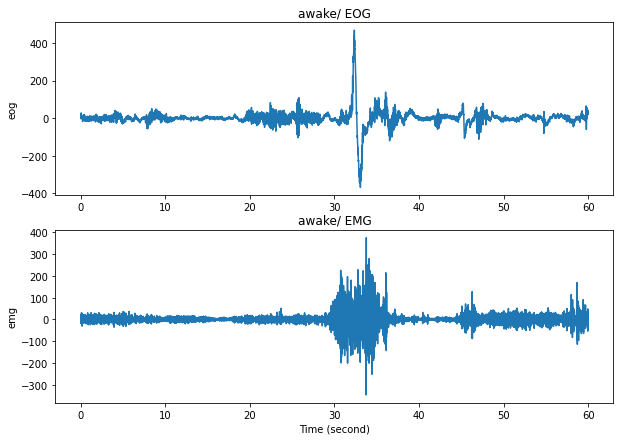

In [ ]:
#View Raw Awake signal
mySample = pd.read_csv(path+class_list[0]+awake[8])
ts = np.arange(0,60,1/fs)
fig = plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(ts,mySample["eog"].iloc[:-1])
plt.ylabel("eog")
plt.title(class_list[0] + ' EOG')
plt.subplot(2,1,2)
plt.plot(ts,mySample["emg"].iloc[:-1])
plt.ylabel("emg")
plt.xlabel("Time (second)")
plt.title(class_list[0] + ' EMG')
plt.show()

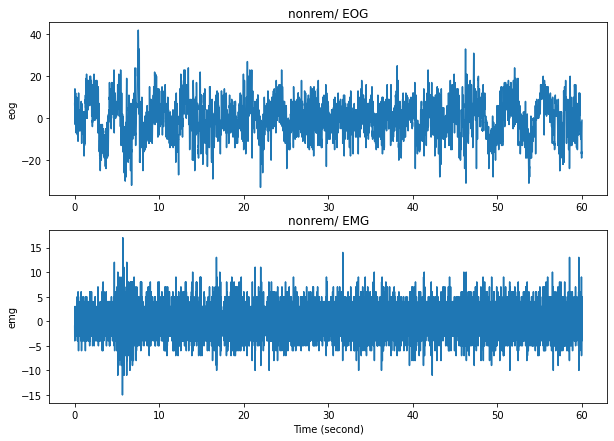

In [ ]:
#View Raw Non REM signal
mySample = pd.read_csv(path+class_list[1]+nrem[7])
ts = np.arange(0,60,1/fs)
fig = plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(ts,mySample["eog"].iloc[:-1])
plt.ylabel("eog")
plt.title(class_list[1] + ' EOG')
plt.subplot(2,1,2)
plt.plot(ts,mySample["emg"].iloc[:-1])
plt.ylabel("emg")
plt.xlabel("Time (second)")
plt.title(class_list[1] + ' EMG')
plt.show()

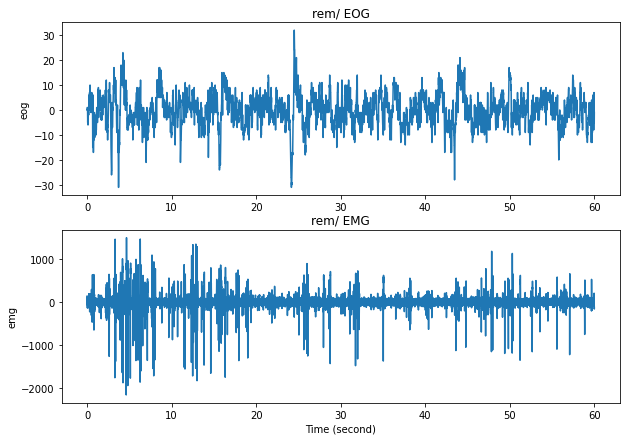

In [ ]:
#View Raw REM signal
mySample = pd.read_csv(path+class_list[2]+rem[7])
ts = np.arange(0,60,1/fs)
fig = plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(ts,mySample["eog"].iloc[:-1])
plt.ylabel("eog")
plt.title(class_list[2] + ' EOG')
plt.subplot(2,1,2)
plt.plot(ts,mySample["emg"].iloc[:-1])
plt.ylabel("emg")
plt.xlabel("Time (second)")
plt.title(class_list[2] + ' EMG')
plt.show()

### Processing

In [ ]:
'''#ignore
def filtered_signal(input_signal,cut_l,cut_h,fs):
    #t1=time.time()
    #global nyq,filtered_emg
    nyq = float(fs/2)
    nrml_cut_l = cut_l/nyq
    nrml_cut_h = cut_h/nyq
    notch_frq = 50/nyq
    notch_frq_l=49/nyq
    notch_frq_h=51/nyq
##    input_signal=input_signal/(10/np.max(input_signal))
    notched_emg=input_signal
    for n in range (1,cut_h//50):
        
        v1,v2=scipy.signal.butter(5,[notch_frq_l*n,notch_frq_h*n],'bandstop',analog=False)
        notched_emg = scipy.signal.filtfilt(v1,v2,notched_emg)
    v1,v2=scipy.signal.butter(4,[nrml_cut_l,nrml_cut_h],'bandpass',analog=False)
    filtered_emg = scipy.signal.filtfilt(v1,v2,notched_emg)
    filtered_emg=normalize_signal(filtered_emg)'''

### Features

In [ ]:
s_signal=mys['emg'].dropna().values


In [ ]:
# Maximum
max_sample_value = max(s_signal)

# Minimum
min_sample_value = min(s_signal)

# Average and Standard Deviation
avg_sample_value = average(s_signal)
std_sample_value = std(s_signal)

time_param_dict = {"Maximum EMG": max_sample_value, "Minimum EMG": min_sample_value, 
                   "Average EMG": avg_sample_value, "Standard Deviation EMG": std_sample_value}

In [ ]:
# Root Mean Square
rms = sqrt(sum(s_signal * s_signal) / len(s_signal))

# Area under the curve
area = cumtrapz(s_signal)

In [ ]:
area

array([ 3.5,  6.5,  5. , ..., 28.5, 25.5, 25. ])

In [ ]:
# Signal Power Spectrum
f, P = welch(s_signal, fs=fs, window='hanning', noverlap=0, nfft=int(256.))

# Total Power and Median Frequency (Frequency that divides the spectrum into two regions with equal power)
area_freq = cumtrapz(P, f, initial=0)
total_power = area_freq[-1]
median_freq = f[where(area_freq >= total_power / 2)[0][0]]
f_max = f[argmax(P)]

In [ ]:
freq, PSD = scipy.signal.periodogram(s_signal, fs)

EMG features: Max, min, mean, std,rms,area, total power,median_freq, max_freq, spectral entropy, MMAV1,MMAV2,zerocrossing, willson amplitude

EOG features: Max, min, mean, std,rms,area, total power



#### Features-EMG Specific

In [ ]:
# Features from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3821366/

def MMAV1(segment , length ):
    mmav_total=[]
    for n in range(0, length):
        if n >=0.25*(length) and n<= 0.75*(length):
            w=1
        elif n <0.25*(length) :
            w= 4*n/length
        elif n>0.75*(length):
            w= 4*(n-length)/length
        mmav=w*segment[n]
        mmav_total=np.append(mmav_total,mmav)
    return(np.sum(mmav)/length)

def MMAV2(segment,length):
    mmav_total=[]
    for n in range (0,length):
        if n>=0.25*(length) and n<=0.75*(length):
            w=1
        else:
            w=0.5
        mmav=w*segment[n]
        mmav_total=np.append(mmav_total,mmav)
    return(np.sum(mmav)/length)
        
def zero_crossing(segment,length):
    #segment=abs(segment)
    count=0
    for n in range(0,length-1):
##        if n+1> length:
##            break
        if segment[n]>0 and segment[n+1]<0:
            count = count+1
        elif segment[n]<0 and segment[n+1]>0:
            count+=1
        else :
            pass
    return count


In [ ]:
#scipy.fft.fft(mys['emg'].dropna().values)
def willison_amp(segment):
    WAMP_threshold=2
    count=0
    for n in range (0,len(segment)-2):
        
        if (segment[n+1]-segment[n]) > WAMP_threshold :
            count +=1
        else:
            pass
    return count

In [ ]:
def slope_sign_change(segment,length): # change in slope # Not using 
    count=0
    #length=len(segment)
    for n in range (0,length-2):
        
        slope1=(segment[n+1]-segment[n])
        slope2=segment[n+2]-segment[n+1]
        #print(slope1)
        break
        if slope1==0:
            pass
        elif slope2/slope1 <0:
            count+=1

        else:
            pass
    return count

In [ ]:
#not using these frequency domain features
def freq_mean(PSD,nyq):
    fn=[]
    len_PSD=len(PSD)
    for n in range(0,len_PSD):
        fi=(n*2*nyq)/(2*len_PSD)
        fn=np.append(fn,fi)
    fmn=(np.sum(fn*PSD))/np.sum(PSD)
    #print np.sum(PSD)
    return fmn

def freq_ratio(PSD,segment_fft_freq):
    #pts=np.vstack((PSD,segment_fft_freq)).reshape((-1),order='F')
    lf_index=np.max(np.nonzero(segment_fft_freq<250))
    lf=np.sum(PSD[0:lf_index])
    hf_index=np.max(np.nonzero(segment_fft_freq>250))
    hf=np.sum(PSD[hf_index:len(PSD)])
    return(hf/lf)
        


def freq_domain(seg,nyq):
        #global FMD_total,FMN_total,MFMD_total,PKF_total
    #for seg in segments:
        segment_fft=scipy.fft(seg)
        segment_fft_freq=np.fft.fftfreq(seg.size,0.5/nyq)

        PSD=segment_fft.real**2/seg.size
        FMD = 0.5*np.sum(PSD)
        FMN =freq_mean(PSD,nyq)
        MFMD=0.5*(np.sum((segment_fft_freq)))
        PKF=np.max(PSD)
        MNP=np.sum(PSD)/len(PSD)
        TTP=np.sum(PSD)
        SM1=np.sum(PSD*(segment_fft_freq))        
        SM2=np.sum(PSD*((segment_fft_freq))**2)
        SM3=np.sum(PSD*((segment_fft_freq))**3)
        FR= freq_ratio(PSD,segment_fft_freq)
        VCF=(SM2/TTP)-(SM1/TTP)**2

        
##        FMD_total=np.append(FMD_total,FMD)
##        FMN_total=np.append(FMN_total,FMN)
##        MFMD_total=np.append(MFMD_total,MFMD)
##        PKF_total=np.append(PKF_total,PKF)
        
        
       
        return(FMN,FMD,MFMD,PKF)

In [ ]:
slope_sign_change(mys['eog'].dropna(),60)

0

In [ ]:
MMAV1(mySample['emg'].dropna(),12000)

3.527777777777778e-06

In [ ]:
len(mySample['emg'].dropna())

12000

#### Pipeline

In [ ]:

col = ['eog_'+ s for s in ['min','max','mean','std','rms','totp','spectralentropy']]+['emg_'+ s for s in ['min','max','mean','std','rms','totp','medfreq','maxfreq','spectralentropy','MMAV1','MMAV2','willson','zero_cross']] 
col


feature_matrix = pd.DataFrame(columns = col)
for idx, fn in enumerate(filenames):
    #import a file
  df = pd.read_csv(fn)
  df.dropna(inplace=True)
  f_eog = []
  f_emg = []
  #f_powerband = []
  for c in range(0,2):
      if c==0:             # if else since, more features from EMG

        # Maximum
        f_eog.append(min(df.iloc[:,c]))
        f_eog.append(max(df.iloc[:,c]))
        f_eog.append(average(df.iloc[:,c]))
        f_eog.append(std(df.iloc[:,c]))
        rms = sqrt(sum(df.iloc[:,c] * df.iloc[:,c]) / len(df.iloc[:,c]))

        # Area under the curve
        area = cumtrapz(df.iloc[:,c])
        f_eog.append(rms)
        #f_eog.append(area)

        f, P = welch(df.iloc[:,c], fs=fs, window='hanning', noverlap=0, nfft=int(256.))

        # Total Power and Median Frequency (Frequency that divides the spectrum into two regions with equal power)
        area_freq = cumtrapz(P, f, initial=0)
        total_power = area_freq[-1]
        #median_freq = f[where(area_freq >= total_power / 2)[0][0]]
        #f_max = f[argmax(P)]
        f_eog.append(total_power)
        freqo, PSDo = scipy.signal.periodogram(df.iloc[:,c], fs)
        #
        #spectral entropy
        pko = PSDo/np.sum(PSDo)
        spectral_entropy_eog = entropy(pko, base=2)
        f_eog.append(spectral_entropy_eog)

      elif c==1:
        f_emg.append(min(df.iloc[:,c]))
        f_emg.append(max(df.iloc[:,c]))
        f_emg.append(average(df.iloc[:,c]))
        f_emg.append(std(df.iloc[:,c]))
        rms = sqrt(sum(df.iloc[:,c] * df.iloc[:,c]) / len(df.iloc[:,c]))

        # Area under the curve
        area = cumtrapz(df.iloc[:,c])
        f_emg.append(rms)
        #f_emg.append(area)

        fm, Pm = welch(df.iloc[:,c], fs=fs, window='hanning', noverlap=0, nfft=int(256.))

        # Total Power and Median Frequency (Frequency that divides the spectrum into two regions with equal power)
        area_freq_emg = cumtrapz(Pm, fm, initial=0)
        total_power_emg = area_freq_emg[-1]
        median_freq = f[where(area_freq_emg >= total_power_emg / 2)[0][0]]
        f_max = f[argmax(Pm)]
        f_emg.append(total_power_emg)
        f_emg.append(median_freq)
        f_emg.append(f_max)

        freq, PSD = scipy.signal.periodogram(df.iloc[:,c], fs)
        #
        #spectral entropy
        pk = PSD/np.sum(PSD)
        spectral_entropy = entropy(pk, base=2)
        f_emg.append(spectral_entropy)
        f_emg.append(MMAV1(df.iloc[:,c],len(df.iloc[:,c])))
        f_emg.append(MMAV2(df.iloc[:,c],len(df.iloc[:,c])))
        #f_emg.append(slope_sign_change(df.iloc[:,c],len(df.iloc[:,c])))
        f_emg.append(willison_amp(df.iloc[:,c]))
        f_emg.append(zero_crossing(df.iloc[:,c],len(df.iloc[:,c])))

        


      
  feature_matrix.loc[idx] = f_eog +f_emg

          


In [ ]:
#feature_matrix['emg_slope_change'].unique()
#feature_matrix.drop(columns=['emg_slope_change'],inplace=True)
#Hence the slope change feature can be dropped as all values are zero
feature_matrix

,eog_min,eog_max,eog_mean,eog_std,eog_rms,eog_totp,eog_spectralentropy,emg_min,emg_max,emg_mean,emg_std,emg_rms,emg_totp,emg_medfreq,emg_maxfreq,emg_spectralentropy,emg_MMAV1,emg_MMAV2,emg_willson,emg_zero_cross
0,-292.0,251.0,0.237083,57.861313,57.861799,1611.937572,6.193327,-105.0,113.0,-0.003750,11.468525,11.468526,126.356666,35.15625,79.68750,9.372585,-1.944444e-07,-1.944444e-07,5046.0,5505.0
1,-34.0,29.0,0.028500,6.897054,6.897113,37.165389,9.530272,-25.0,24.0,-0.000167,6.013069,6.013069,36.324573,34.37500,35.93750,10.923293,2.777778e-08,2.777778e-08,4424.0,3492.0
2,-144.0,134.0,0.327417,25.648591,25.650681,365.735992,7.529361,-72.0,94.0,-0.001250,14.476685,14.476685,216.063414,33.59375,22.65625,11.073188,1.111111e-07,1.111111e-07,4801.0,4016.0
3,-159.0,170.0,0.200250,39.724379,39.724884,1123.254523,7.160511,-26.0,17.0,0.003500,2.271304,2.271307,4.608840,35.93750,43.75000,9.902669,-1.388889e-07,-1.388889e-07,1824.0,2870.0
4,-291.0,379.0,0.504167,49.185779,49.188362,1304.705788,6.800371,-476.0,558.0,-0.000083,44.806567,44.806567,2172.991903,39.84375,46.09375,11.239505,-8.333333e-08,-8.333333e-08,4415.0,3753.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,-50.0,57.0,0.006583,10.766532,10.766534,65.403711,7.171131,-50.0,53.0,-0.001583,5.274506,5.274506,29.686877,19.53125,14.84375,9.763716,-8.333333e-08,-8.333333e-08,1857.0,1927.0
626,-79.0,72.0,-0.042583,12.873271,12.873341,63.751023,6.803703,-47.0,29.0,-0.001167,1.201249,1.201249,0.876698,26.56250,79.68750,11.075009,-2.777778e-08,-2.777778e-08,100.0,615.0
627,-49.0,44.0,0.017000,10.011812,10.011826,74.786687,7.831667,-75.0,100.0,-0.000833,5.681417,5.681417,29.122830,17.96875,16.40625,10.615256,5.555556e-08,5.555556e-08,1458.0,1447.0
628,-42.0,45.0,-0.162333,7.843053,7.844733,32.512241,6.471678,-7.0,8.0,-0.000333,1.697154,1.697154,2.903869,60.15625,79.68750,7.110542,-5.555556e-08,-5.555556e-08,2070.0,4540.0


## Filtering-Avoided

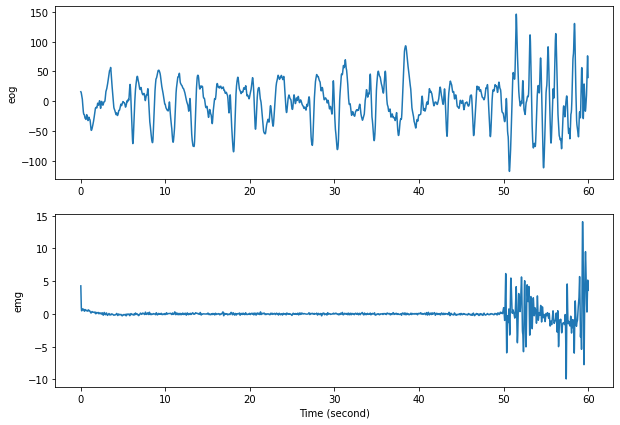

In [ ]:
#Plot filtered sample: Awake- 
dfs = pd.read_csv(path + class_list[0] + "0_subj_10.csv")
dfs.dropna(inplace=True)


fc = np.array([0.1,15.0])
Wn = fc/(fs/2)
b, a = signal.butter(3, Wn, btype ='bandpass', analog=False)
dfs["eog_filt"] = signal.filtfilt(b, a, dfs["eog"])
dfs["emg_filt"] = signal.filtfilt(b, a, dfs["emg"])
#dfs["accZ_filt"] = signal.filtfilt(b, a, dfs["accZ"])
ts = np.arange(0,60,1/fs)
fig = plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(ts,dfs["eog_filt"])
plt.ylabel("eog")
plt.subplot(2,1,2)
plt.plot(ts,dfs["emg_filt"])
plt.ylabel("emg")

plt.xlabel("Time (second)")
plt.show()


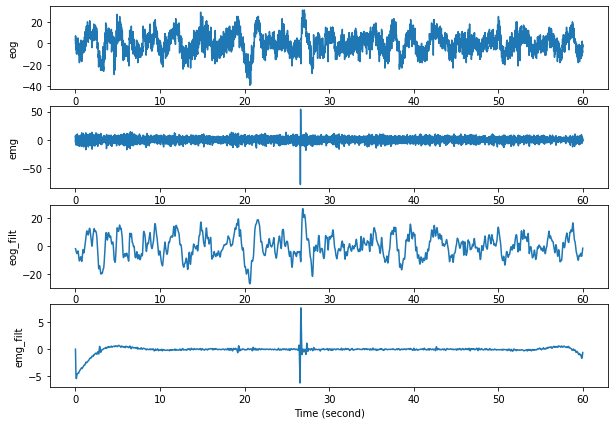

In [ ]:
#Plot filtered sample: NREM
dfs = pd.read_csv(path + class_list[1] + "0_subj_1.csv")
dfs.dropna(inplace=True)


fc = np.array([0.1,5.0])
Wn = fc/(fs/2)
b, a = signal.butter(3, Wn, btype ='bandpass', analog=False)
dfs["eog_filt"] = signal.filtfilt(b, a, dfs["eog"])
dfs["emg_filt"] = signal.filtfilt(b, a, dfs["emg"])
#dfs["accZ_filt"] = signal.filtfilt(b, a, dfs["accZ"])
ts = np.arange(0,60,1/fs)
fig = plt.figure(figsize=(10,7))
plt.subplot(4,1,1)
plt.plot(ts,dfs["eog"])
plt.ylabel("eog")
plt.subplot(4,1,2)
plt.plot(ts,dfs["emg"])
plt.ylabel("emg")
plt.subplot(4,1,3)
plt.plot(ts,dfs["eog_filt"])
plt.ylabel("eog_filt")
plt.subplot(4,1,4)
plt.plot(ts,dfs["emg_filt"])
plt.ylabel("emg_filt")

plt.xlabel("Time (second)")
plt.show()


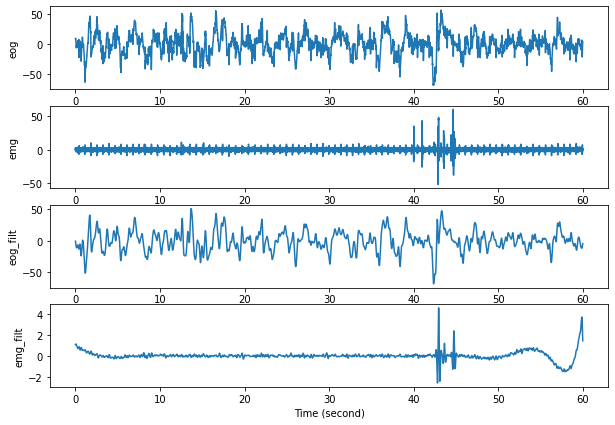

In [ ]:
#Plot filtered sample: REM
dfs = pd.read_csv(path + class_list[2] + "1023_subj_17.csv")
dfs.dropna(inplace=True)


fc = np.array([0.1,4.0])
#fc=60
Wn = fc/(fs/2)
b, a = signal.butter(4, Wn, btype ='bandpass', analog=False)
dfs["eog_filt"] = signal.filtfilt(b, a, dfs["eog"])
dfs["emg_filt"] = signal.filtfilt(b, a, dfs["emg"])
#dfs["accZ_filt"] = signal.filtfilt(b, a, dfs["accZ"])
ts = np.arange(0,60,1/fs)
fig = plt.figure(figsize=(10,7))
plt.subplot(4,1,1)
plt.plot(ts,dfs["eog"])
plt.ylabel("eog")
plt.subplot(4,1,2)
plt.plot(ts,dfs["emg"])
plt.ylabel("emg")
plt.subplot(4,1,3)
plt.plot(ts,dfs["eog_filt"])
plt.ylabel("eog_filt")
plt.subplot(4,1,4)
plt.plot(ts,dfs["emg_filt"])
plt.ylabel("emg_filt")

plt.xlabel("Time (second)")
plt.show()

Since essential information is missed out and EMG lies in the 50Hz freq range, filtering may remove important information, hence the step is avoided

## Machine learning

In [ ]:
#filenames
# Not yet used Test set, Training and Leave one out CV

In [ ]:
from xgboost import XGBClassifier
X = feature_matrix
y = np.array(labels)
#
#shuffle data
X, y = shuffle(X, y, random_state=20)
#
#model
clfx= XGBClassifier()
#clf = KNeighborsClassifier(n_neighbors=10, weights = 'distance')
#
#leave-one-out
y_pred = np.array([])
y_true = np.array([])
loo = LeaveOneOut()
for train_index, test_index in loo.split(feature_matrix):
    X_train = X.iloc[train_index,:]
    X_test = X.iloc[test_index,:]
    y_train = y[train_index]
    y_test = y[test_index]
    #
    #normalize data
    X_train_mean = np.mean(X_train, axis=0)
    X_train_std = np.std(X_train, axis=0)
    X_train_norm = (X_train - X_train_mean)/X_train_std
    X_test_norm = (X_test - X_train_mean)/X_train_std
    #
    #train
    clfx.fit(X_train_norm, y_train)
    #
    #test
    y_pred = np.append(y_pred,clf.predict(X_test_norm))
    y_true = np.append(y_true,y_test)
#
#metrics
print("Labels: Awake,NREM, REM")
print("Confusion matrix")
print(metrics.confusion_matrix(y_true, y_pred))
print("Precision")
print(metrics.precision_score(y_true, y_pred, average=None))
print("Recall")
print(metrics.recall_score(y_true, y_pred, average=None))
print("F1 score")
print(metrics.f1_score(y_true, y_pred, average=None))
print(metrics.f1_score(y_true, y_pred, average='weighted'))

Labels: Awake,NREM, REM
Confusion matrix
[[180  47   2]
 [ 26 192  20]
 [  5  25 133]]
Precision
[0.85308057 0.72727273 0.85806452]
Recall
[0.7860262  0.80672269 0.81595092]
F1 score
[0.81818182 0.76494024 0.83647799]
0.802802103501194


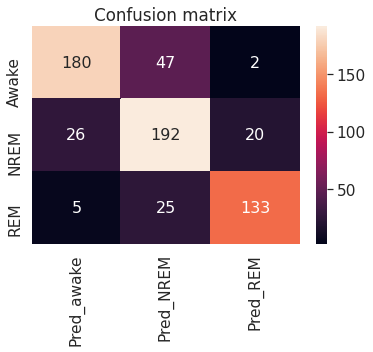

In [ ]:
import seaborn as sn
df_cm = pd.DataFrame(metrics.confusion_matrix(y_true, y_pred), ['Awake','NREM','REM'],['Pred_awake','Pred_NREM','Pred_REM'] )
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
plt.title('Confusion matrix of Predictions')

plt.show()

In [ ]:
from xgboost import XGBClassifier
X = feature_matrix
y = np.array(labels)
#
#shuffle data
X, y = shuffle(X, y, random_state=20)
#
#model
#clf = XGBClassifier()
clfk = KNeighborsClassifier(n_neighbors=15, weights = 'distance')
#
#leave-one-out
y_pred = np.array([])
y_true = np.array([])
loo = LeaveOneOut()
for train_index, test_index in loo.split(feature_matrix):
    X_train = X.iloc[train_index,:]
    X_test = X.iloc[test_index,:]
    y_train = y[train_index]
    y_test = y[test_index]
    #
    #normalize data
    X_train_mean = np.mean(X_train, axis=0)
    X_train_std = np.std(X_train, axis=0)
    X_train_norm = (X_train - X_train_mean)/X_train_std
    X_test_norm = (X_test - X_train_mean)/X_train_std
    #
    #train
    clfk.fit(X_train_norm, y_train)
    #
    #test
    y_pred = np.append(y_pred,clfk.predict(X_test_norm))
    y_true = np.append(y_true,y_test)
#
#metrics
print("Labels: Awake,NREM, REM")
print("Confusion matrix")
print(metrics.confusion_matrix(y_true, y_pred))
print("Precision")
print(metrics.precision_score(y_true, y_pred, average=None))
print("Recall")
print(metrics.recall_score(y_true, y_pred, average=None))
print("F1 score")
print(metrics.f1_score(y_true, y_pred, average=None))
print(metrics.f1_score(y_true, y_pred, average='weighted'))

Labels: Awake,NREM, REM
Confusion matrix
[[154  73   2]
 [ 39 159  40]
 [  3  33 127]]
Precision
[0.78571429 0.6        0.75147929]
Recall
[0.67248908 0.66806723 0.7791411 ]
F1 score
[0.72470588 0.63220676 0.76506024]
0.7002026588626141


In [ ]:
from sklearn.linear_model import LogisticRegression
X = feature_matrix
y = np.array(labels)
#
#shuffle data
X, y = shuffle(X, y, random_state=20)
#
#model
clflog = LogisticRegression()
#clf = KNeighborsClassifier(n_neighbors=10, weights = 'distance')
#
#leave-one-out
y_pred = np.array([])
y_true = np.array([])
loo = LeaveOneOut()
for train_index, test_index in loo.split(feature_matrix):
    X_train = X.iloc[train_index,:]
    X_test = X.iloc[test_index,:]
    y_train = y[train_index]
    y_test = y[test_index]
    #
    #normalize data
    X_train_mean = np.mean(X_train, axis=0)
    X_train_std = np.std(X_train, axis=0)
    X_train_norm = (X_train - X_train_mean)/X_train_std
    X_test_norm = (X_test - X_train_mean)/X_train_std
    #
    #train
    clflog.fit(X_train_norm, y_train)
    #
    #test
    y_pred = np.append(y_pred,clflog.predict(X_test_norm))
    y_true = np.append(y_true,y_test)
#
#metrics
print("Labels: Awake,NREM, REM")
print("Confusion matrix")
print(metrics.confusion_matrix(y_true, y_pred))
print("Precision")
print(metrics.precision_score(y_true, y_pred, average=None))
print("Recall")
print(metrics.recall_score(y_true, y_pred, average=None))
print("F1 score")
print(metrics.f1_score(y_true, y_pred, average=None))
print(metrics.f1_score(y_true, y_pred, average='weighted'))

Labels: Awake,NREM, REM
Confusion matrix
[[171  52   6]
 [ 22 173  43]
 [  6  28 129]]
Precision
[0.85929648 0.68379447 0.7247191 ]
Recall
[0.74672489 0.72689076 0.79141104]
F1 score
[0.79906542 0.70468432 0.75659824]
0.7524227970190478


XGBoost F1: 0.8

KNN F1: 0.7

Logistic regression F1:0.752


From these results it has been observed that XGboost has both a higher precision and F1, so it is better to look for hyperparameter tuning with XGboost

#### Model Tuning

In [ ]:
from scipy import stats
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
import sklearn
#from sklearn import cross_validation
X = feature_matrix
y = np.array(labels)
#
#shuffle data
X, y = shuffle(X, y, random_state=20)

X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_norm = (X - X_mean)/X_std

clf_xgb = XGBClassifier()
param_dist = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.6),
              'subsample': stats.uniform(0.3, 0.9),
              'max_depth': [3, 5, 6, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.9),
              'min_child_weight': [1, 2, 3, 4]
             }
scorer = sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average = 'weighted')
#numFolds = 10
#kfold_5 = cross_validation.KFold(n = len(X), shuffle = True, n_folds = numFolds)

clfcv = RandomizedSearchCV(clf_xgb, 
                         param_distributions = param_dist,
                         cv = 10,  
                         n_iter = 50, 
                         scoring = scorer, 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1,random_state=20)

In [ ]:
clfcv.fit(X_norm,y)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.4min finished


RandomizedSearchCV(cv=10, error_score=0,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sca...
                                        'max_depth': [3, 5, 6, 8, 9],
                                        'min_child_weight': [1, 2, 3, 4],
                                 

In [ ]:
best_score = clfcv.best_score_
best_params = clfcv.best_estimator_

In [ ]:
best_score

0.8140923535870822

In [ ]:
best_params

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9757837407096945, gamma=0,
              learning_rate=0.011547777951720852, max_delta_step=0, max_depth=9,
              min_child_weight=3, missing=None, n_estimators=781, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8790578507265092, verbosity=1)

#### Test set pipeline

In [ ]:
#test set
t_filenames = []
t_labels = []
pathtest='/content/drive/MyDrive/Bio-analytics/Data/Test/'
for idx, cl in enumerate(class_list):
    files_list = glob.glob(pathtest + cl + "/*.csv")
    t_filenames.extend(files_list)
    t_labels.extend([idx]*len(files_list))

In [ ]:
col = ['eog_'+ s for s in ['min','max','mean','std','rms','totp','spectralentropy']]+['emg_'+ s for s in ['min','max','mean','std','rms','totp','medfreq','maxfreq','spectralentropy','MMAV1','MMAV2','willson','zero_cross']] 
col


feature_matrix_test = pd.DataFrame(columns = col)
for idx,fn in enumerate(t_filenames):
    #import a file
  df = pd.read_csv(fn)
  df.dropna(inplace=True)
  f_eog = []
  f_emg = []
  #f_powerband = []
  for c in range(0,2):
      if c==0:             # if else since, more features from EMG

        # Maximum
        f_eog.append(min(df.iloc[:,c]))
        f_eog.append(max(df.iloc[:,c]))
        f_eog.append(average(df.iloc[:,c]))
        f_eog.append(std(df.iloc[:,c]))
        rms = sqrt(sum(df.iloc[:,c] * df.iloc[:,c]) / len(df.iloc[:,c]))

        # Area under the curve
        area = cumtrapz(df.iloc[:,c])
        f_eog.append(rms)
        #f_eog.append(area)

        f, P = welch(df.iloc[:,c], fs=fs, window='hanning', noverlap=0, nfft=int(256.))

        # Total Power and Median Frequency (Frequency that divides the spectrum into two regions with equal power)
        area_freq = cumtrapz(P, f, initial=0)
        total_power = area_freq[-1]
        #median_freq = f[where(area_freq >= total_power / 2)[0][0]]
        #f_max = f[argmax(P)]
        f_eog.append(total_power)
        freqo, PSDo = scipy.signal.periodogram(df.iloc[:,c], fs)
        #
        #spectral entropy
        pko = PSDo/np.sum(PSDo)
        spectral_entropy_eog = entropy(pko, base=2)
        f_eog.append(spectral_entropy_eog)

      elif c==1:
        f_emg.append(min(df.iloc[:,c]))
        f_emg.append(max(df.iloc[:,c]))
        f_emg.append(average(df.iloc[:,c]))
        f_emg.append(std(df.iloc[:,c]))
        rms = sqrt(sum(df.iloc[:,c] * df.iloc[:,c]) / len(df.iloc[:,c]))

        # Area under the curve
        area = cumtrapz(df.iloc[:,c])
        f_emg.append(rms)
        #f_emg.append(area)

        fm, Pm = welch(df.iloc[:,c], fs=fs, window='hanning', noverlap=0, nfft=int(256.))

        # Total Power and Median Frequency (Frequency that divides the spectrum into two regions with equal power)
        area_freq_emg = cumtrapz(Pm, fm, initial=0)
        total_power_emg = area_freq_emg[-1]
        median_freq = f[where(area_freq_emg >= total_power_emg / 2)[0][0]]
        f_max = f[argmax(Pm)]
        f_emg.append(total_power_emg)
        f_emg.append(median_freq)
        f_emg.append(f_max)

        freq, PSD = scipy.signal.periodogram(df.iloc[:,c], fs)
        #
        #spectral entropy
        pk = PSD/np.sum(PSD)
        spectral_entropy = entropy(pk, base=2)
        f_emg.append(spectral_entropy)
        f_emg.append(MMAV1(df.iloc[:,c],len(df.iloc[:,c])))
        f_emg.append(MMAV1(df.iloc[:,c],len(df.iloc[:,c])))
        #f_emg.append(slope_sign_change(df.iloc[:,c],len(df.iloc[:,c])))
        f_emg.append(willison_amp(df.iloc[:,c]))
        f_emg.append(zero_crossing(df.iloc[:,c],len(df.iloc[:,c])))

        


      
  feature_matrix_test.loc[idx] = f_eog +f_emg

In [ ]:
X_testf = feature_matrix_test
y_testf = np.array(t_labels)
#
#shuffle data
X_testf, y_testf = shuffle(X_testf, y_testf, random_state=20)

In [ ]:
X
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_norm = (X - X_mean)/X_std
#X_test_norm = (X_test - X_train_mean)/X_train_std

In [ ]:
X_testf_norm = (X_testf - X_mean)/X_std

In [ ]:
#XGboost fit- untuned model
finalclf=XGBClassifier()
finalclf.fit(X_norm,y)
y_pred=finalclf.predict(X_testf_norm )
print("Labels: Awake,NREM, REM")
print("Confusion matrix")
print(metrics.confusion_matrix(y_testf, y_pred))
print("Precision")
print(metrics.precision_score(y_testf, y_pred, average=None))
print("Recall")
print(metrics.recall_score(y_testf, y_pred, average=None))
print("F1 score")
print(metrics.f1_score(y_testf, y_pred, average=None))
print(metrics.f1_score(y_testf, y_pred, average='weighted'))



Labels: Awake,NREM, REM
Confusion matrix
[[42 16  2]
 [ 7 46  6]
 [ 0  7 24]]
Precision
[0.85714286 0.66666667 0.75      ]
Recall
[0.7        0.77966102 0.77419355]
F1 score
[0.7706422  0.71875    0.76190476]
0.7484255315275957


In [ ]:
best_params

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8743486622067934, gamma=0,
              learning_rate=0.2647266858179337, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=480, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9502307860011932, verbosity=1)

In [ ]:
#XGboost fit- tuned model
finalclf1=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8743486622067934, gamma=0,
              learning_rate=0.2647266858179337, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=480, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9502307860011932, verbosity=1)
finalclf1.fit(X_norm,y)
y_pred=finalclf1.predict(X_testf_norm )
print("Labels: Awake,NREM, REM")
print("Confusion matrix")
print(metrics.confusion_matrix(y_testf, y_pred))
print("Precision")
print(metrics.precision_score(y_testf, y_pred, average=None))
print("Recall")
print(metrics.recall_score(y_testf, y_pred, average=None))
print("F1 score")
print(metrics.f1_score(y_testf, y_pred, average=None))
print(metrics.f1_score(y_testf, y_pred, average='weighted'))



Labels: Awake,NREM, REM
Confusion matrix
[[44 14  2]
 [ 6 48  5]
 [ 0  8 23]]
Precision
[0.88       0.68571429 0.76666667]
Recall
[0.73333333 0.81355932 0.74193548]
F1 score
[0.8        0.74418605 0.75409836]
0.7685601728300927


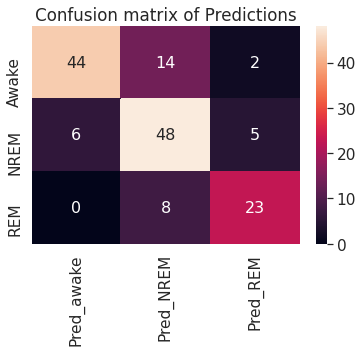

In [ ]:
df_cm = pd.DataFrame(metrics.confusion_matrix(y_testf, y_pred), ['Awake','NREM','REM'],['Pred_awake','Pred_NREM','Pred_REM'] )
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
plt.title('Confusion matrix of Predictions')

plt.show()

In [ ]:
np.unique(y_testf,return_counts=True)

(array([0, 1, 2]), array([60, 59, 31]))

### Result

Although an F1 of 0.81 was obtained upon Random search CV on the train set with 10 folds and 50 iterations
The test set had an F1 score of 0.76 with the tuned model while a normal XGboost returned an F1 score of 0.74